In [22]:
# Setting up packages, directories and configs
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF,FastICA, PCA
from sklearn.preprocessing import StandardScaler
import os
import codecs
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'font.size': 25})



IPA_CSV_DIR = '/home/jerome/Documents/ipa-data.csv'
UNITS_TXT = '/mnt/ssd/espnet/egs/low-resource-language/asr1-slavic-align/data/lang_1char/train_units.txt'
COLOR_TYPE_CONS = 'Manner' # choose from Place or Manner
COLOR_TYPE_VOWEL = 'Backness' # choose from Height or 'Backness'
SUBSAMPLE_FIT = 20 # subsample factor for fitting
SUBSAMPLE_PLOT = 5 # subsample factor for plotting
exp_dirs = ['/mnt/ssd/espnet/egs/low-resource-language/asr1-slavic-align/exp/train_pytorch_slavic_transformer_ctc_cross_base_6_seg',
           '/mnt/ssd/espnet/egs/low-resource-language/asr1-slavic-align/exp/train_pytorch_l15_transformer_ctc_cross_rgm3_run_k1_lmd_0.01_e3_seg'] # choose ERM and another method to compare with


PLOT_SAVE_DIR = '/mnt/ssd/espnet/egs/low-resource-language/asr1-slavic-align/tsne' # where to save tsne plots
MAT_SAVE_DIR = '/mnt/ssd/espnet/egs/low-resource-language/asr1-slavic-align/conf_mat' # where to save confusion matrix
PLOT_CAT = 'consonant' # phones selected during tsne fitting; choose from 'consonant', 'vowel', 'consonant vowel'
COMP_FLAG ='rgm' # type of experiment you compared against erm and the string should be in exp_dirs[1]

In [2]:
# Get the articulatory attributes for each phone

ipa_df = pd.read_csv(IPA_CSV_DIR)
ipa_df.iloc[74,5] = "postalveolar;velar"


f_train_units = codecs.open(UNITS_TXT).readlines()
train_units = []
train_units_dict = {}

id2phs = {}

places = []
manners = []
heights = []
backs = []


for unit_line in f_train_units:
    id2phs[unit_line.replace('\n','').split()[1]] = unit_line.replace('\n','').split()[0]
    train_units.append(unit_line.replace('\n','').split()[0])
print(id2phs)

for unit in train_units:
    cur_df = ipa_df[ipa_df['Symbol'] == unit]
    if len(cur_df) > 0:
        if isinstance(np.array(cur_df['Manner_of_Articulation'])[0], str) and 'consonant' in PLOT_CAT:
            place = np.array(cur_df['Place_of_Articulation'])[0]
            manner = np.array(cur_df['Manner_of_Articulation'])[0]
            train_units_dict[unit] = ['consonant', place, manner]
            places.append(place)
            manners.append(manner)
            
        elif isinstance(np.array(cur_df['Height'])[0], str) and 'vowel' in PLOT_CAT:
            back = np.array(cur_df['Backness'])[0]
            height = np.array(cur_df['Height'])[0]
            train_units_dict[unit] = ['vowel', height, back]
            heights.append(height)
            backs.append(back)

            
places = list(set(places))
manners = list(set(manners))
heights = list(set(heights))
backs = list(set(backs))

print('Place', places, '\nNumbers: ',len(places))
print('Manner', manners, '\nNumbers: ',len(manners))
print('Height', heights, '\nNumbers: ',len(heights))
print('Back', backs, '\nNumbers: ',len(backs))


color_palette = sns.color_palette(n_colors = 12)


{'1': '<unk>', '2': 'a', '3': 'b', '4': 'c', '5': 'd', '6': 'f', '7': 'i', '8': 'j', '9': 'k', '10': 'l', '11': 'm', '12': 'n', '13': 'o', '14': 'p', '15': 'r', '16': 's', '17': 't', '18': 'u', '19': 'v', '20': 'w', '21': 'x', '22': 'z', '23': 'ŋ', '24': 'ɐ', '25': 'ɔ', '26': 'ɕ', '27': 'ɖ', '28': 'ɛ', '29': 'ɟ', '30': 'ɡ', '31': 'ɤ', '32': 'ɦ', '33': 'ɨ', '34': 'ɪ', '35': 'ɫ', '36': 'ɲ', '37': 'ʂ', '38': 'ʃ', '39': 'ʐ', '40': 'ʑ', '41': 'ʒ', '42': 'ʲ', '43': 'ˈ', '44': 'ː', '45': '̃', '46': '̝', '47': '̪'}
Place ['postalveolar', 'retroflex', 'labial-velar', 'palatal', 'alveolo-palatal', 'glottal', 'velar', 'labiodental', 'alveolar', 'bilabial', 'dental;alveolar'] 
Numbers:  11
Manner ['lateral approximant', 'fricative', 'trill', 'approximant', 'plosive', 'nasal'] 
Numbers:  6
Height [] 
Numbers:  0
Back [] 
Numbers:  0


In [3]:
# Load data and subsample the phones in each language

all_embeddings = []
all_labels = []
all_langs =[]
lang2phs = {}
for data_dir in exp_dirs:
    embeddings = []
    labels = []
    langs = []
    lang_dirs = os.listdir(data_dir)
    for lang_dir in lang_dirs:
        lang_embeddings = []
        lang_labels = []
        if 'result' not in lang_dir and 'log' not in lang_dir:
            json_fn = os.path.join(data_dir, lang_dir, 'embedding.1.json')
            with open(json_fn,'rb') as f:
                lang_data = pickle.load(f)
                for key in sorted(lang_data.keys()):
                    ph_label = id2phs[str(lang_data[key]['GT'][0])]
                    if ph_label in train_units_dict.keys():
                        
                        lang_embeddings.append(lang_data[key]['embedding'])
                        lang_labels.append(ph_label)
                    
            unique_labels = np.unique(lang_labels)
            
            lang_embeddings = np.array(lang_embeddings)
            lang_labels = np.array(lang_labels)
            #print(lang_embeddings.shape)
            
            subsampled_embeddings = []
            subsampled_labels = []
            
            for label in unique_labels:
                #print(label)
                cur_embeddings = lang_embeddings[lang_labels == label]
                #print(cur_embeddings.shape)
                cur_labels = lang_labels[lang_labels == label]
                subsampled_embeddings.append(cur_embeddings[:int(len(cur_labels) / SUBSAMPLE_FIT) + 1])
                subsampled_labels.append(cur_labels[:int(len(cur_labels) / SUBSAMPLE_FIT) + 1])
                
            subsampled_embeddings = np.concatenate(subsampled_embeddings, axis = 0)
            subsampled_labels = np.concatenate(subsampled_labels, axis = 0)
            print(subsampled_embeddings.shape, subsampled_labels.shape)
            
            embeddings.append(subsampled_embeddings)
            labels.append(subsampled_labels)
            langs.append(np.array([lang_dir] * len(subsampled_labels)))
            
            if lang_dir not in lang2phs.keys():
                lang2phs[lang_dir] = unique_labels
    embeddings = np.concatenate(embeddings, axis = 0)
    labels = np.concatenate(labels, axis = 0)
    langs = np.concatenate(langs, axis = 0)
    all_embeddings.append(embeddings)
    all_labels.append(labels)
    all_langs.append(langs)
        
print(lang2phs)

(1634, 256) (1634,)
(2150, 256) (2150,)
(1894, 256) (1894,)
(4375, 256) (4375,)
(1634, 256) (1634,)
(2150, 256) (2150,)
(1894, 256) (1894,)
(4375, 256) (4375,)
{'decode_eval_Polish_decode': array(['b', 'd', 'f', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'v',
       'w', 'x', 'z', 'ŋ', 'ɕ', 'ɡ', 'ɲ', 'ʂ', 'ʐ', 'ʑ'], dtype='<U1'), 'decode_eval_Bulgarian_decode': array(['b', 'd', 'f', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'v',
       'w', 'x', 'z', 'ɡ', 'ɫ', 'ʃ', 'ʒ'], dtype='<U1'), 'decode_eval_Croatian_decode': array(['b', 'd', 'f', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'v',
       'x', 'z', 'ɕ', 'ɡ', 'ɲ', 'ʃ', 'ʑ', 'ʒ'], dtype='<U1'), 'decode_eval_Czech_decode': array(['b', 'c', 'd', 'f', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't',
       'v', 'x', 'z', 'ɟ', 'ɡ', 'ɦ', 'ɲ', 'ʃ', 'ʒ'], dtype='<U1')}


In [4]:
# print(all_embeddings[0].shape, all_embeddings[1].shape)

all_sampled_rs_tot = np.concatenate([all_embeddings[0], all_embeddings[1]])
print(all_sampled_rs_tot.shape)

all_sampled_rs_tot_standardized = StandardScaler().fit_transform(all_sampled_rs_tot)

# print(all_sampled_rs_tot_standardized.mean(axis = 0))
# print(all_sampled_rs_tot_standardized.std(axis = 0))

viz_pca = PCA(n_components = 100)
all_sampled_rs_pcaed = viz_pca.fit_transform(all_sampled_rs_tot_standardized)
variance = viz_pca.explained_variance_ratio_
# print(variance)
print(sum(variance))
tsne = TSNE(n_components=2, verbose=1, perplexity=50)#
tsne_trans = tsne.fit_transform(all_sampled_rs_pcaed)
print('TSNE/PCA DONE!')

(20106, 256)
0.9555350962327793
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20106 samples in 0.176s...
[t-SNE] Computed neighbors for 20106 samples in 66.958s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20106
[t-SNE] Computed conditional probabilities for sample 2000 / 20106
[t-SNE] Computed conditional probabilities for sample 3000 / 20106
[t-SNE] Computed conditional probabilities for sample 4000 / 20106
[t-SNE] Computed conditional probabilities for sample 5000 / 20106
[t-SNE] Computed conditional probabilities for sample 6000 / 20106
[t-SNE] Computed conditional probabilities for sample 7000 / 20106
[t-SNE] Computed conditional probabilities for sample 8000 / 20106
[t-SNE] Computed conditional probabilities for sample 9000 / 20106
[t-SNE] Computed conditional probabilities for sample 10000 / 20106
[t-SNE] Computed conditional probabilities for sample 11000 / 20106
[t-SNE] Computed conditional probabilities for sample 12000 / 20106
[t-SNE] Computed

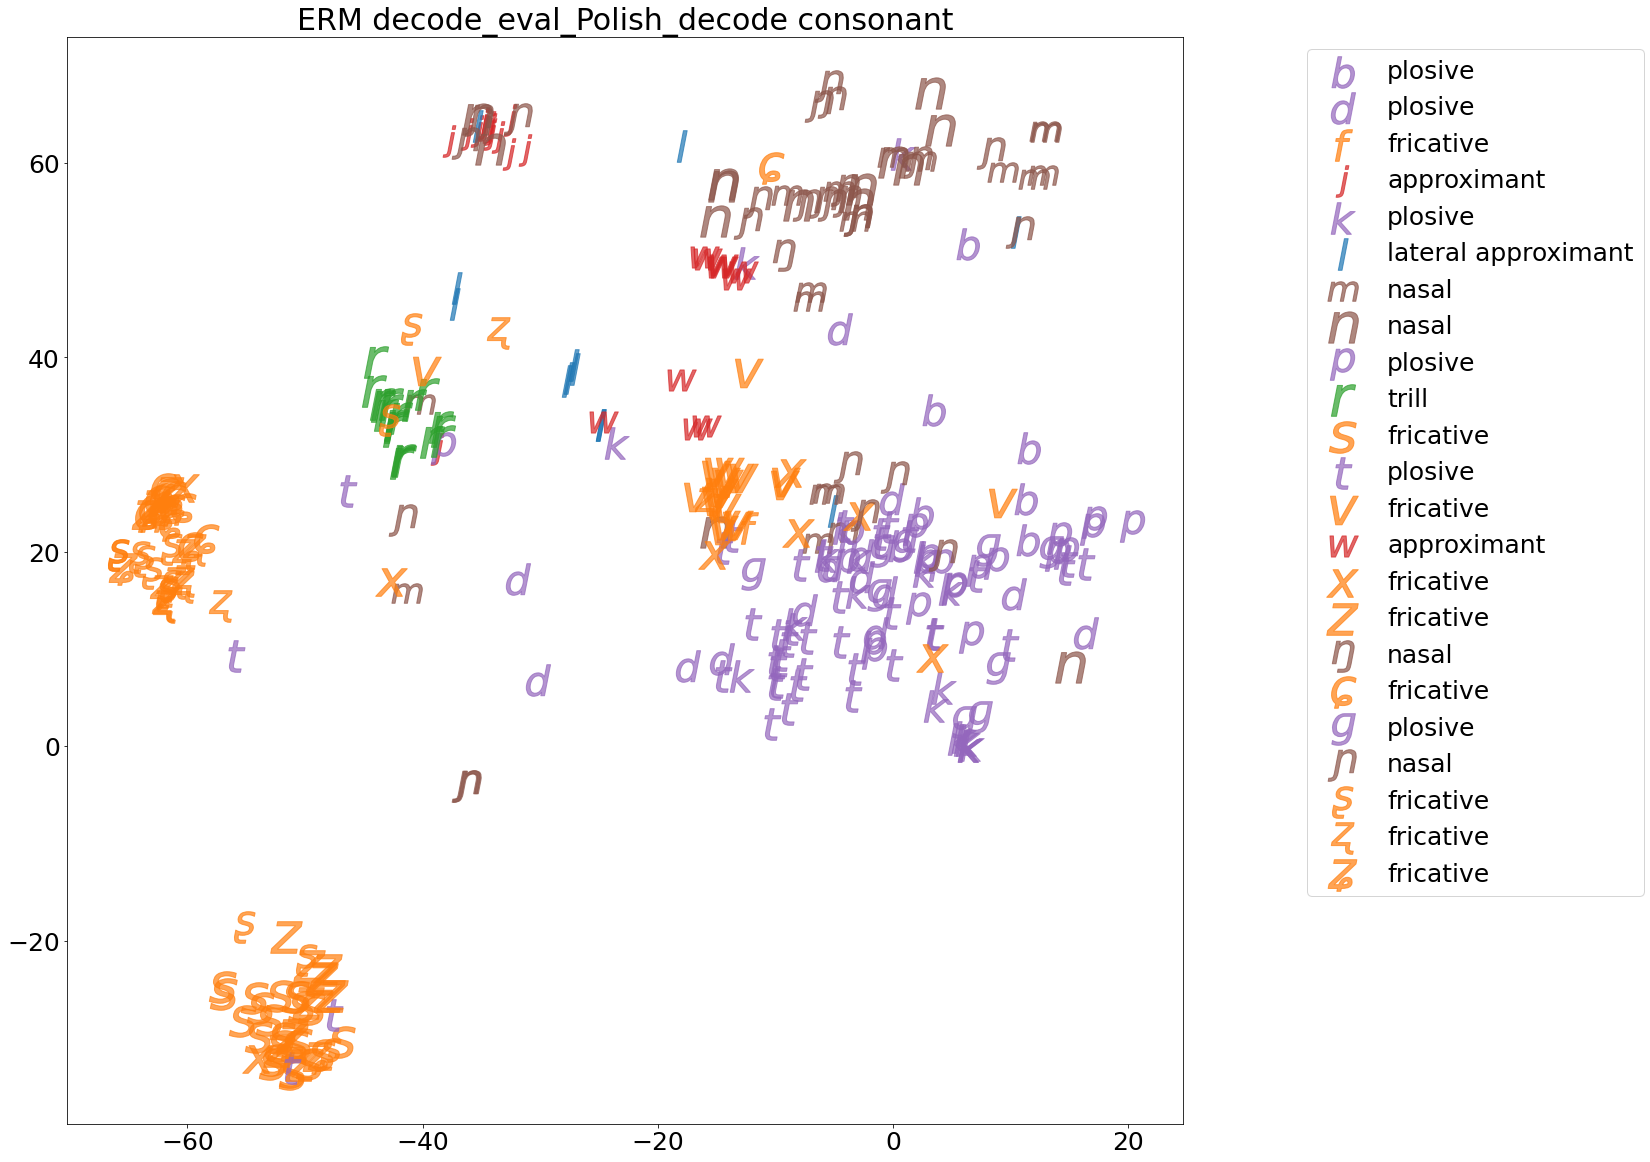

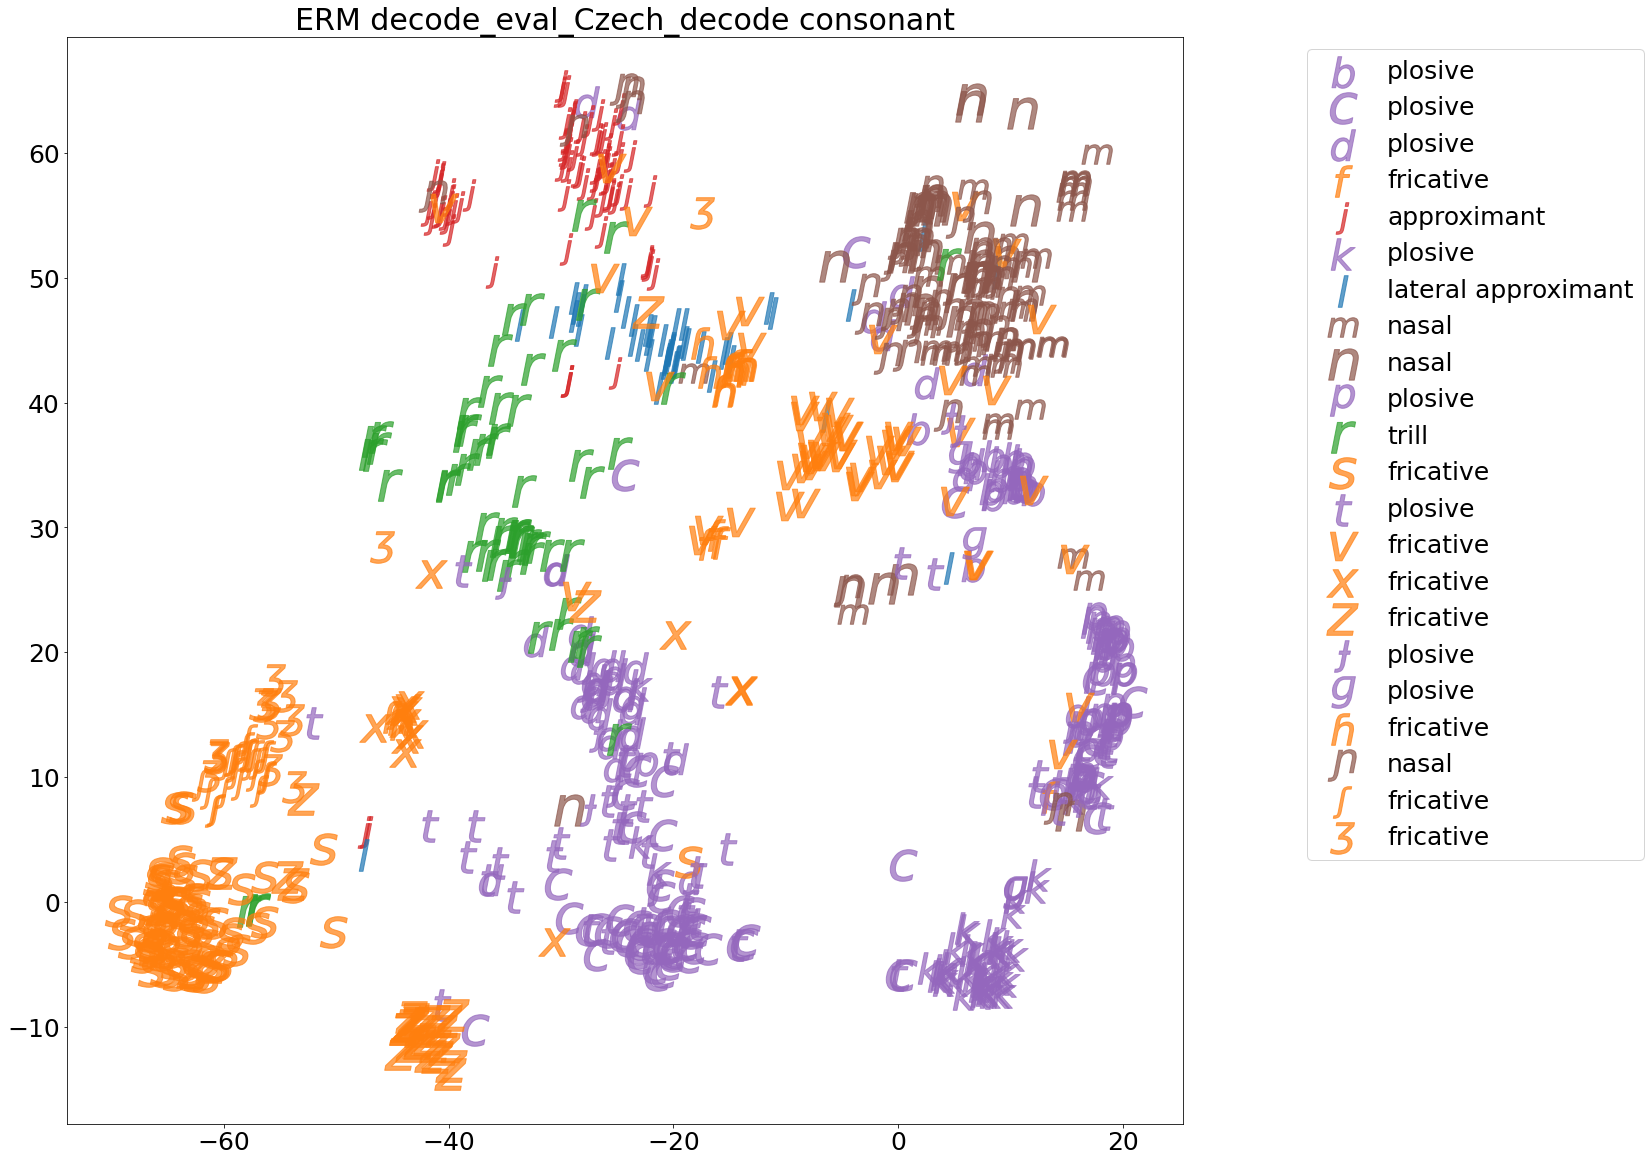

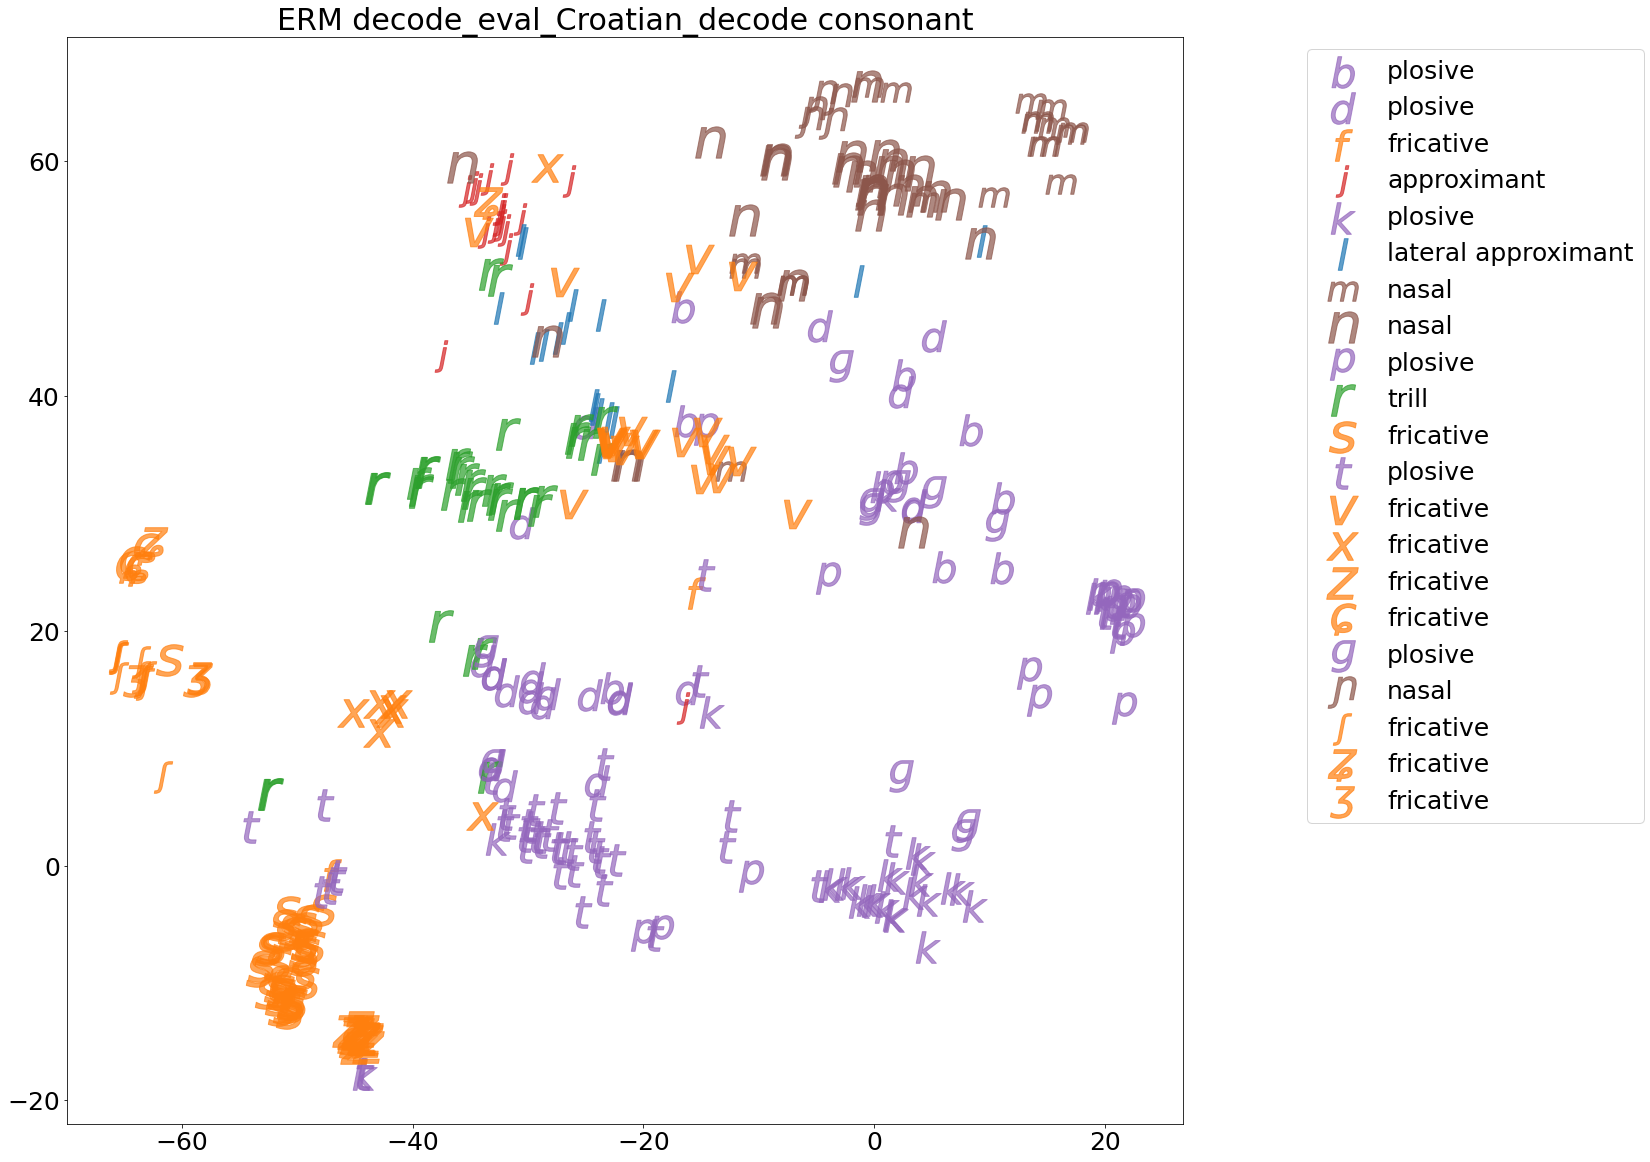

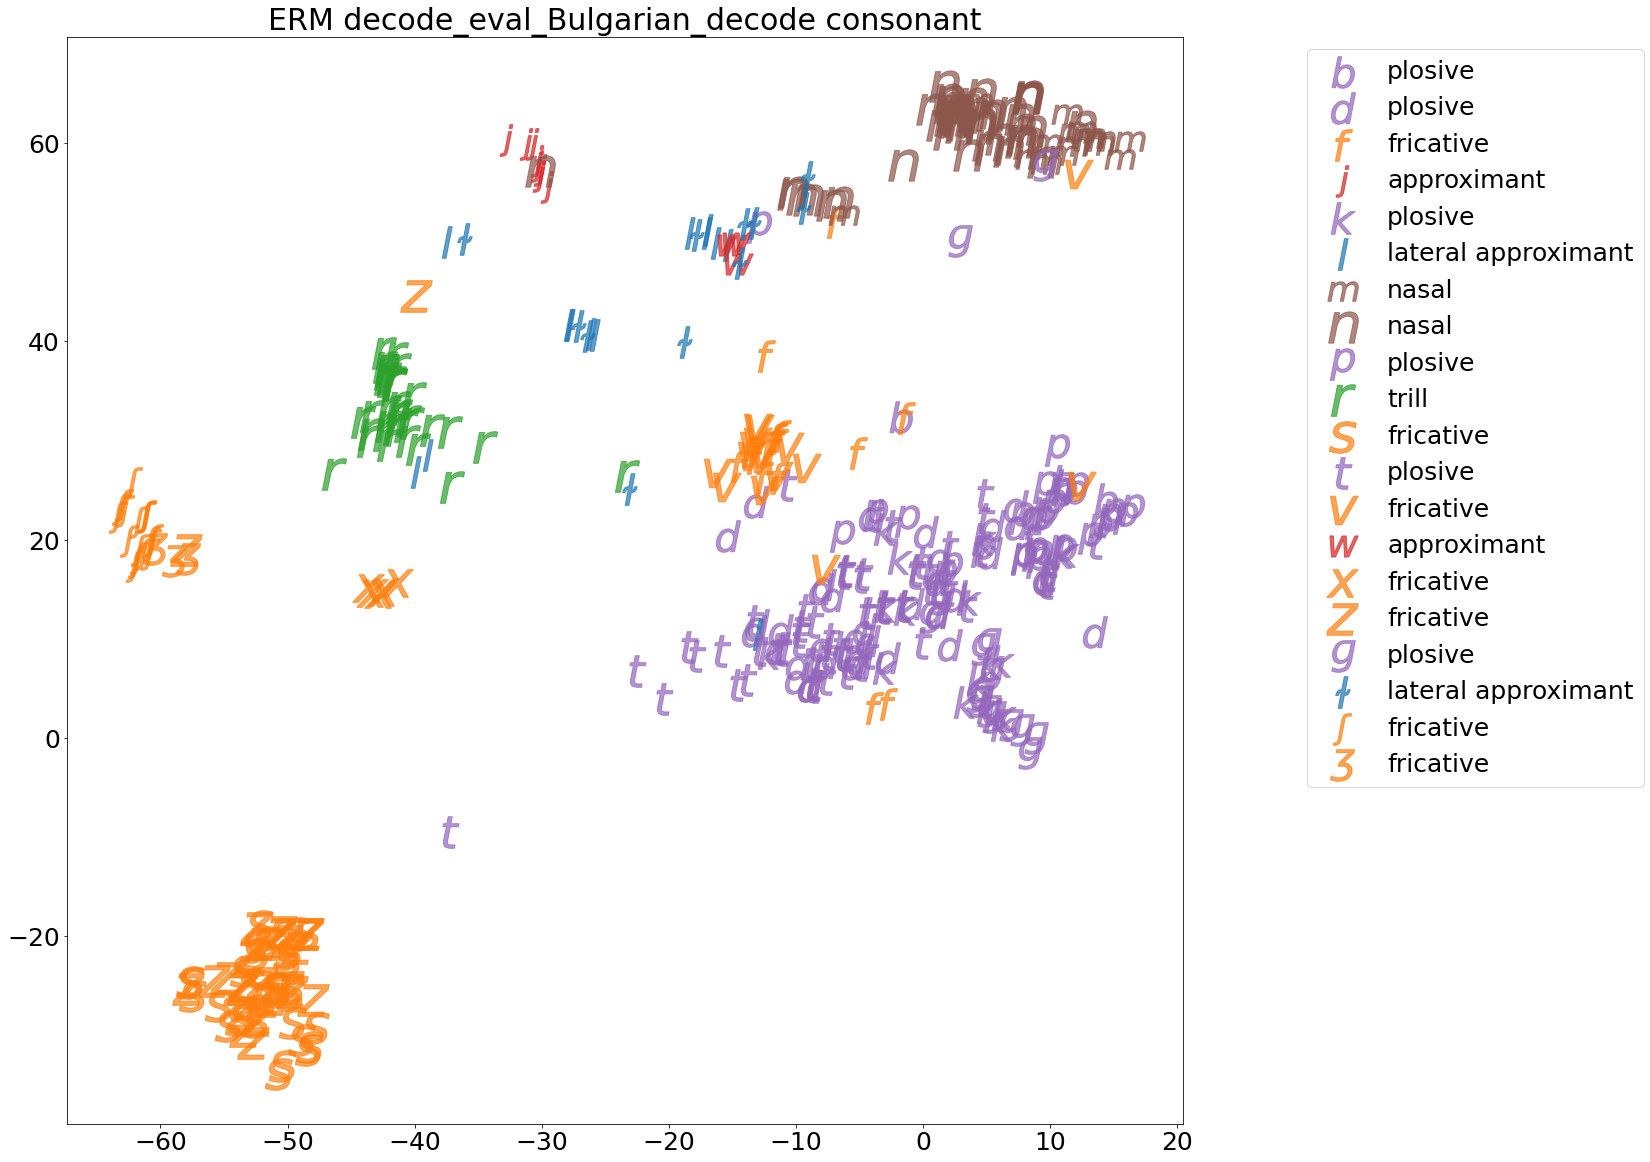

In [25]:
# ERM

cur_embeddings = all_embeddings[0]
cur_labels = all_labels[0]
cur_langs = all_langs[0]
cur_save_dir = os.path.join(PLOT_SAVE_DIR,exp_dirs[0].split('/')[-1])
os.makedirs(cur_save_dir,exist_ok = True)

cur_tsne = tsne_trans[:len(all_embeddings[0])]

unique_langs = lang2phs.keys()


for lang in sorted(unique_langs, reverse = True):
    for cat in PLOT_CAT.split():
        fig = plt.figure(figsize = (20,20))
        ax = fig.add_subplot(111)

        for ph in lang2phs[lang]:
            prop = train_units_dict[ph]
            if prop[0] == cat:
                choose_flag = np.logical_and(cur_labels == ph, cur_langs == lang)
                cur_cur_tsne = cur_tsne[choose_flag]
                cur_cur_tsne = cur_cur_tsne[:int(len(cur_cur_tsne) / SUBSAMPLE_PLOT) + 1]
                if prop[0] == 'vowel' and COLOR_TYPE_VOWEL == 'Height':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[1], marker = '$' + ph + '$', 
                               color = color_palette[heights.index(prop[1])], alpha = 0.7, s = 1000)
                if prop[0] == 'vowel' and COLOR_TYPE_VOWEL == 'Backness':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[2], marker = '$' + ph + '$', 
                               color = color_palette[backs.index(prop[2])], alpha = 0.7, s = 1000)
                if prop[0] == 'consonant' and COLOR_TYPE_CONS == 'Place':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[1], marker = '$' + ph + '$', 
                               color = color_palette[places.index(prop[1])], alpha = 0.7, s = 1000)
                if prop[0] == 'consonant' and COLOR_TYPE_CONS == 'Manner':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[2], marker = '$' + ph + '$', 
                               color = color_palette[manners.index(prop[2])], alpha = 0.7, s = 1000)
        ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')      
        ax.set_title('ERM ' + lang + ' ' + cat)
        fig.savefig(os.path.join(cur_save_dir, 'ERM ' + lang + ' ' + cat + '.png'))

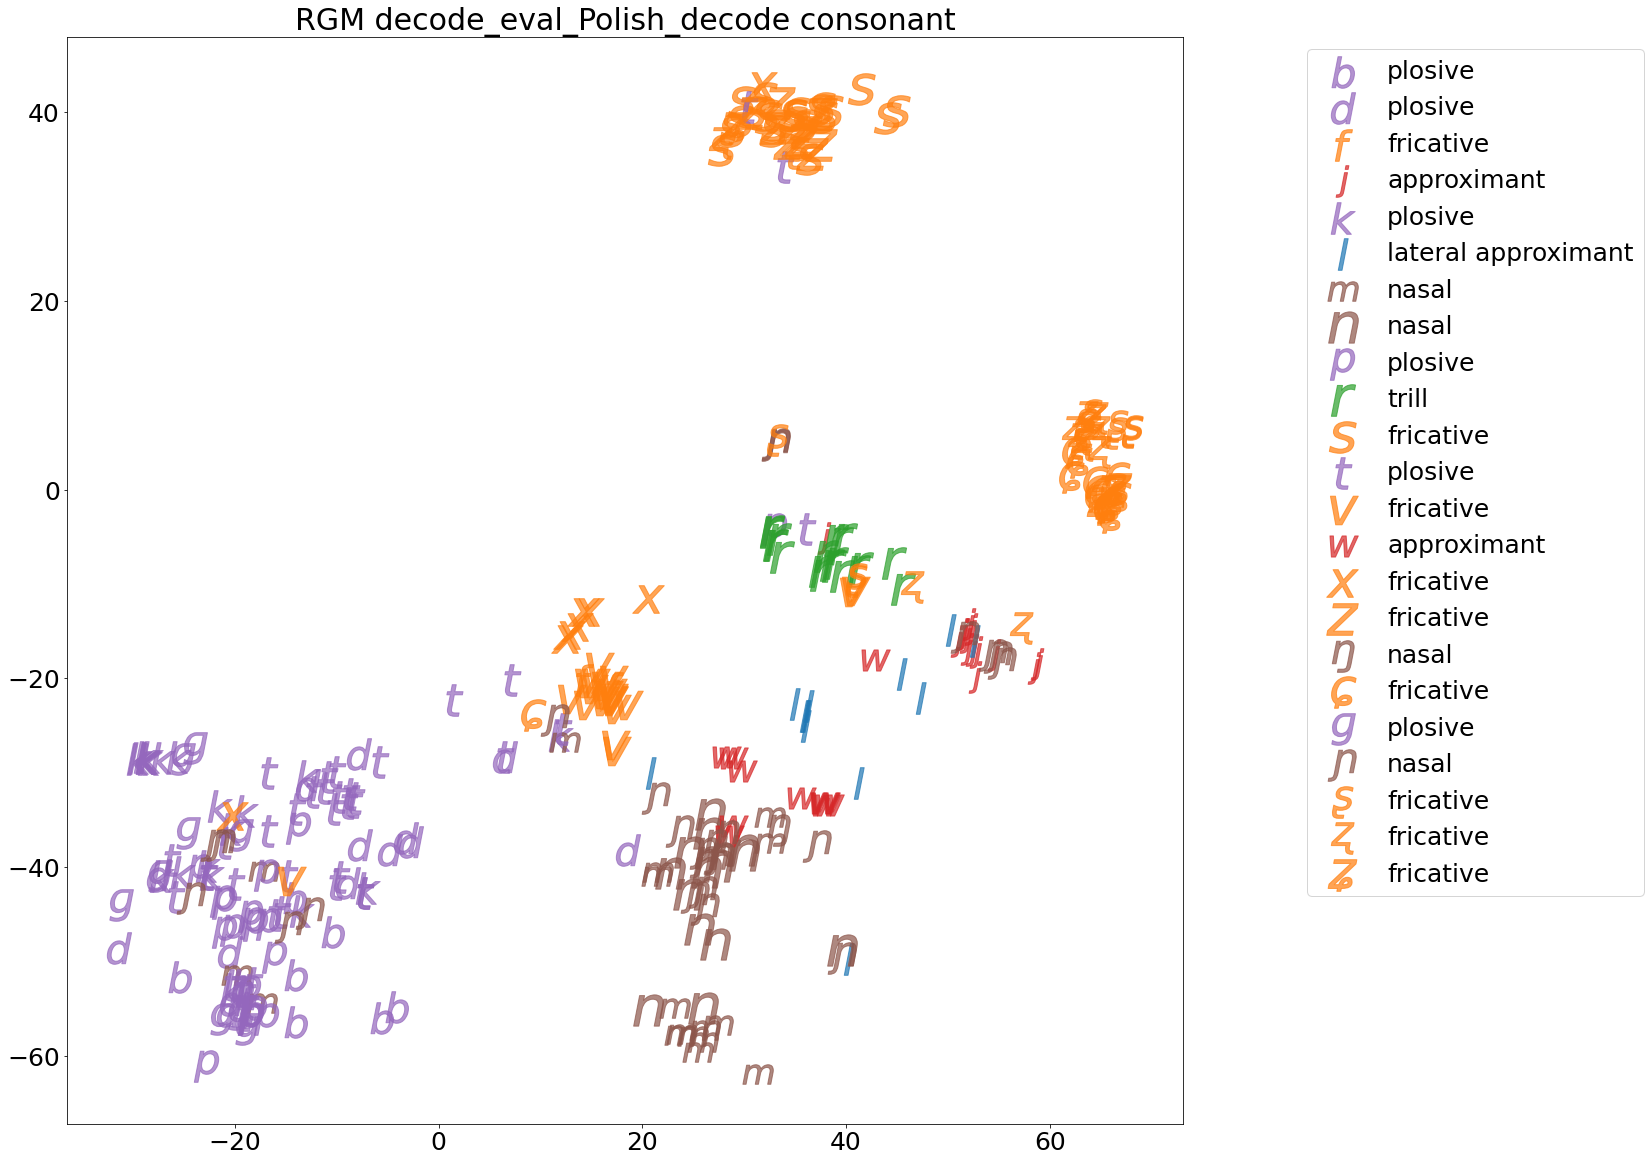

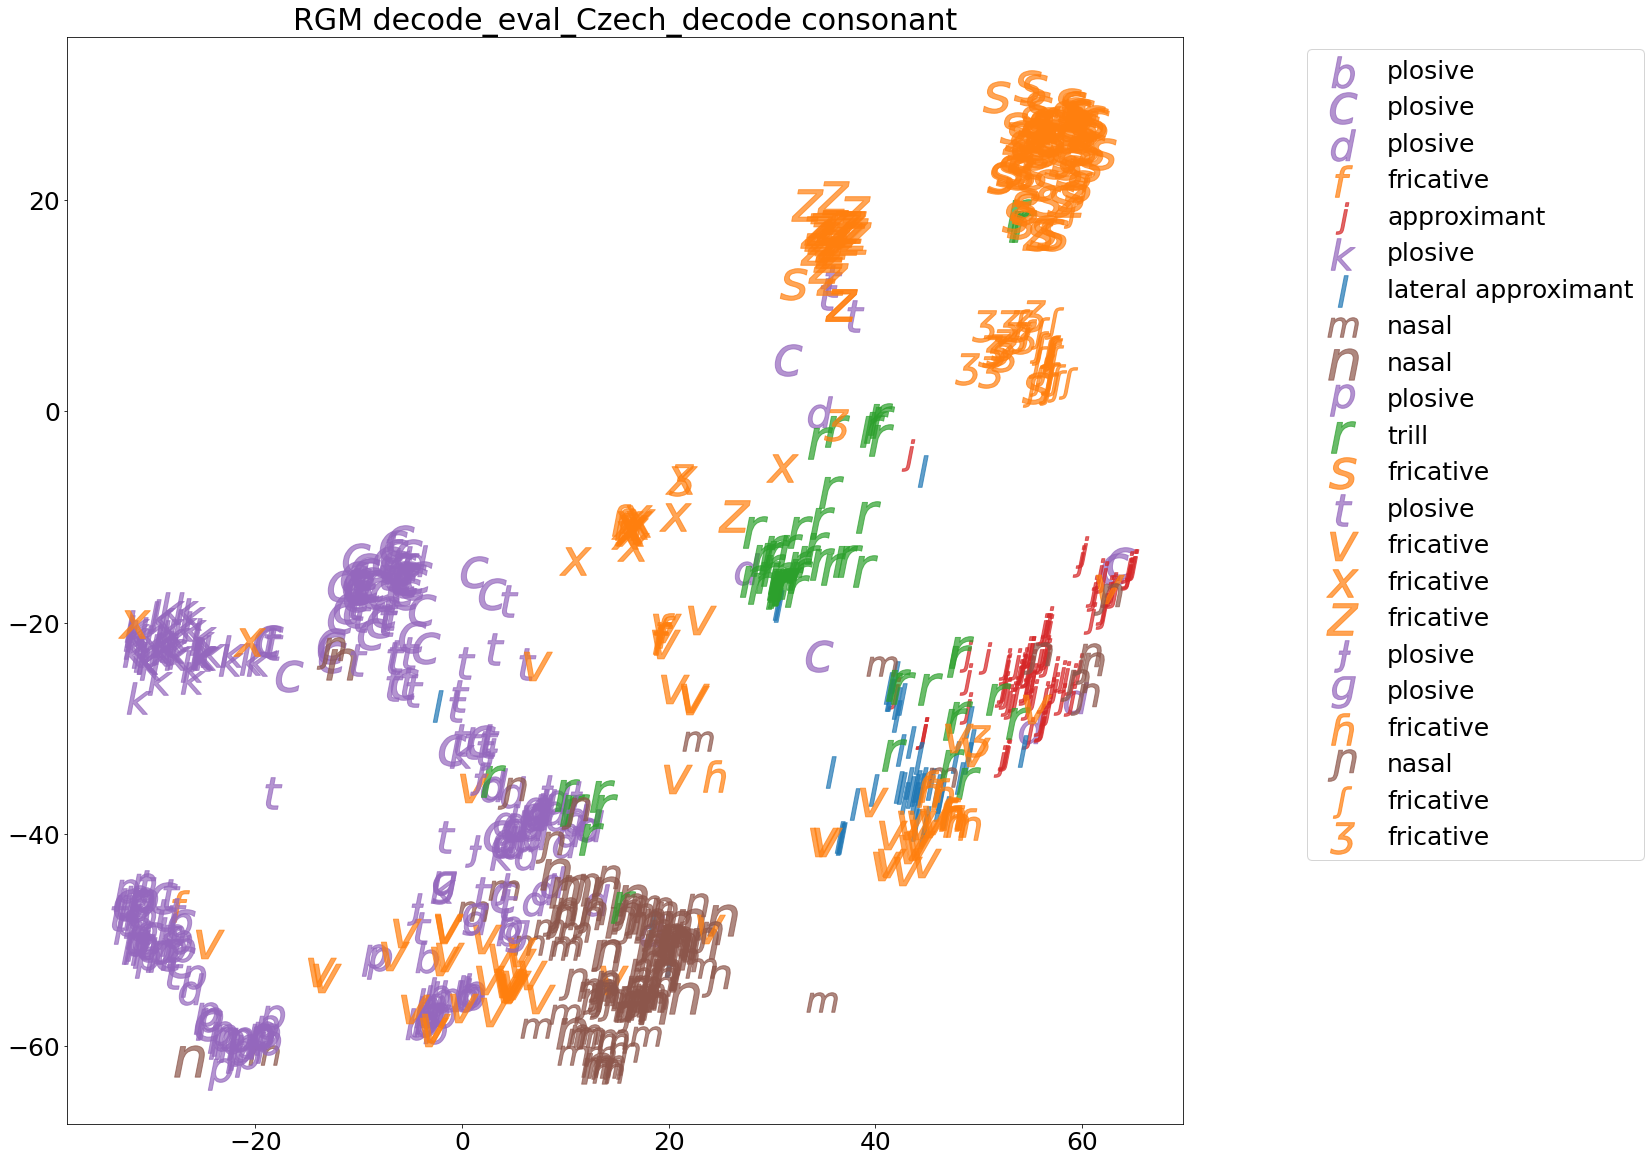

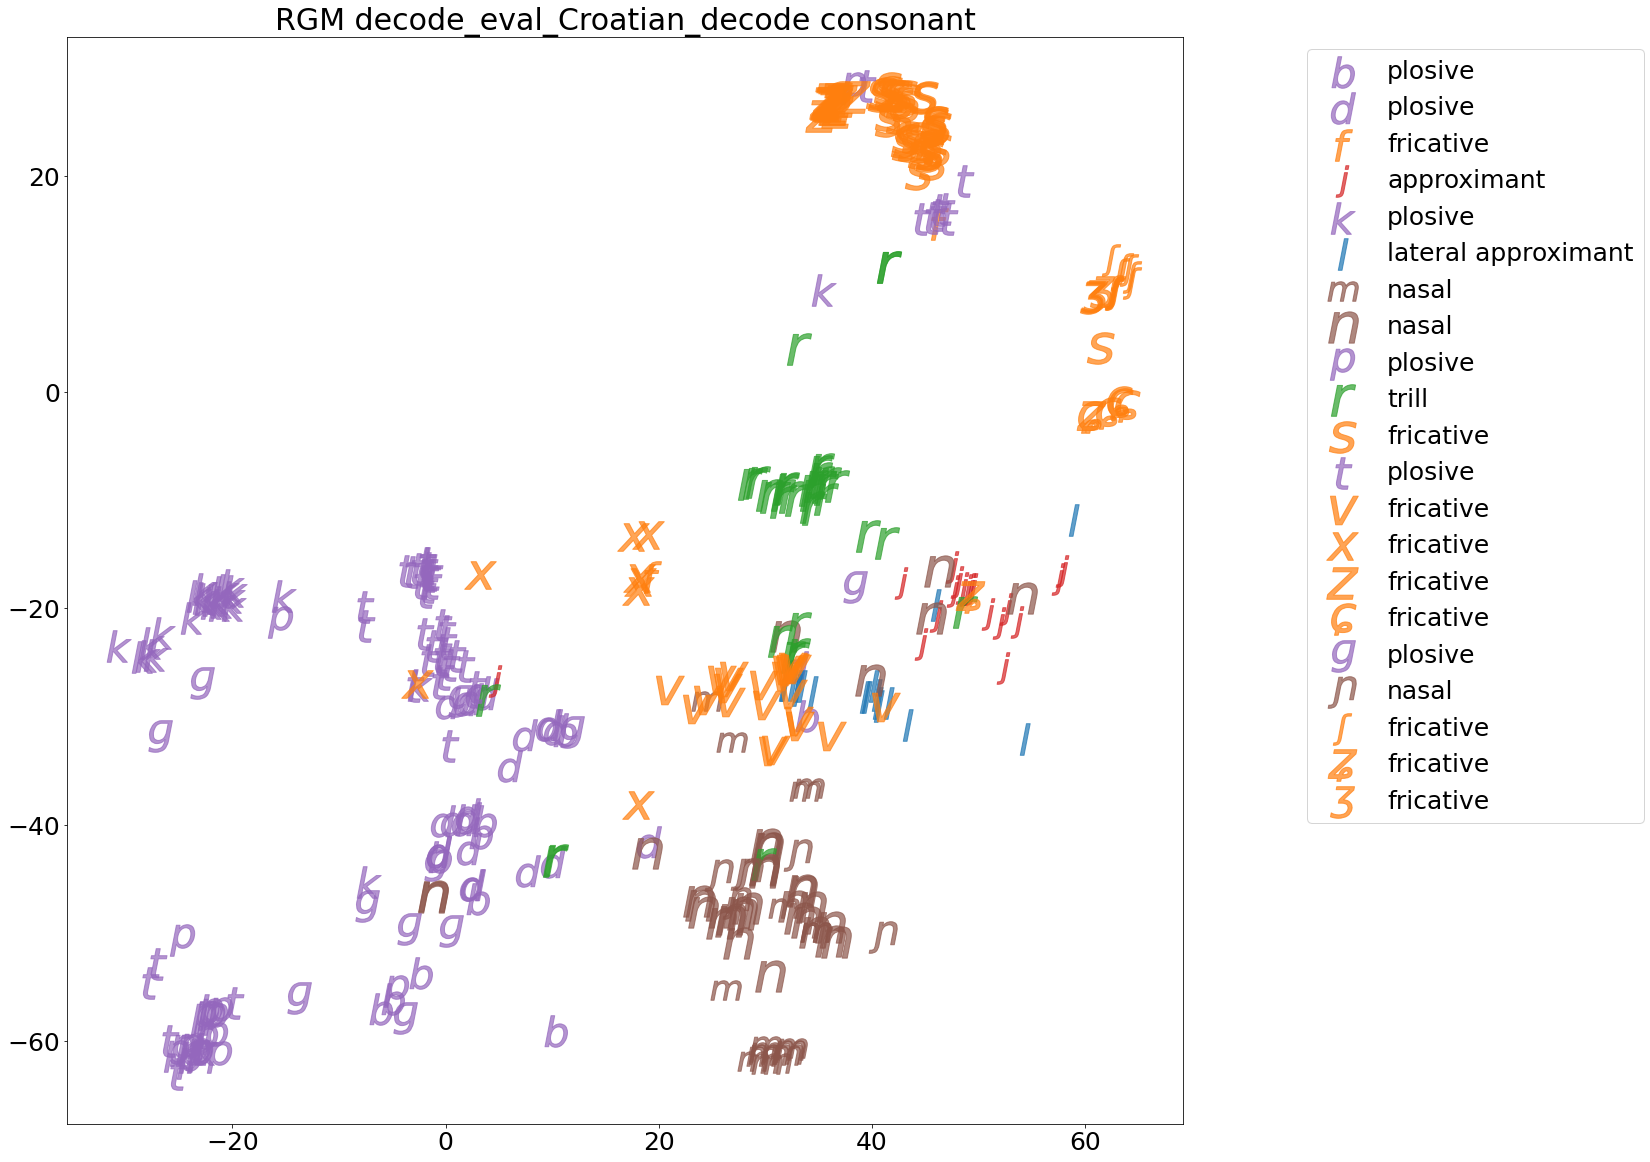

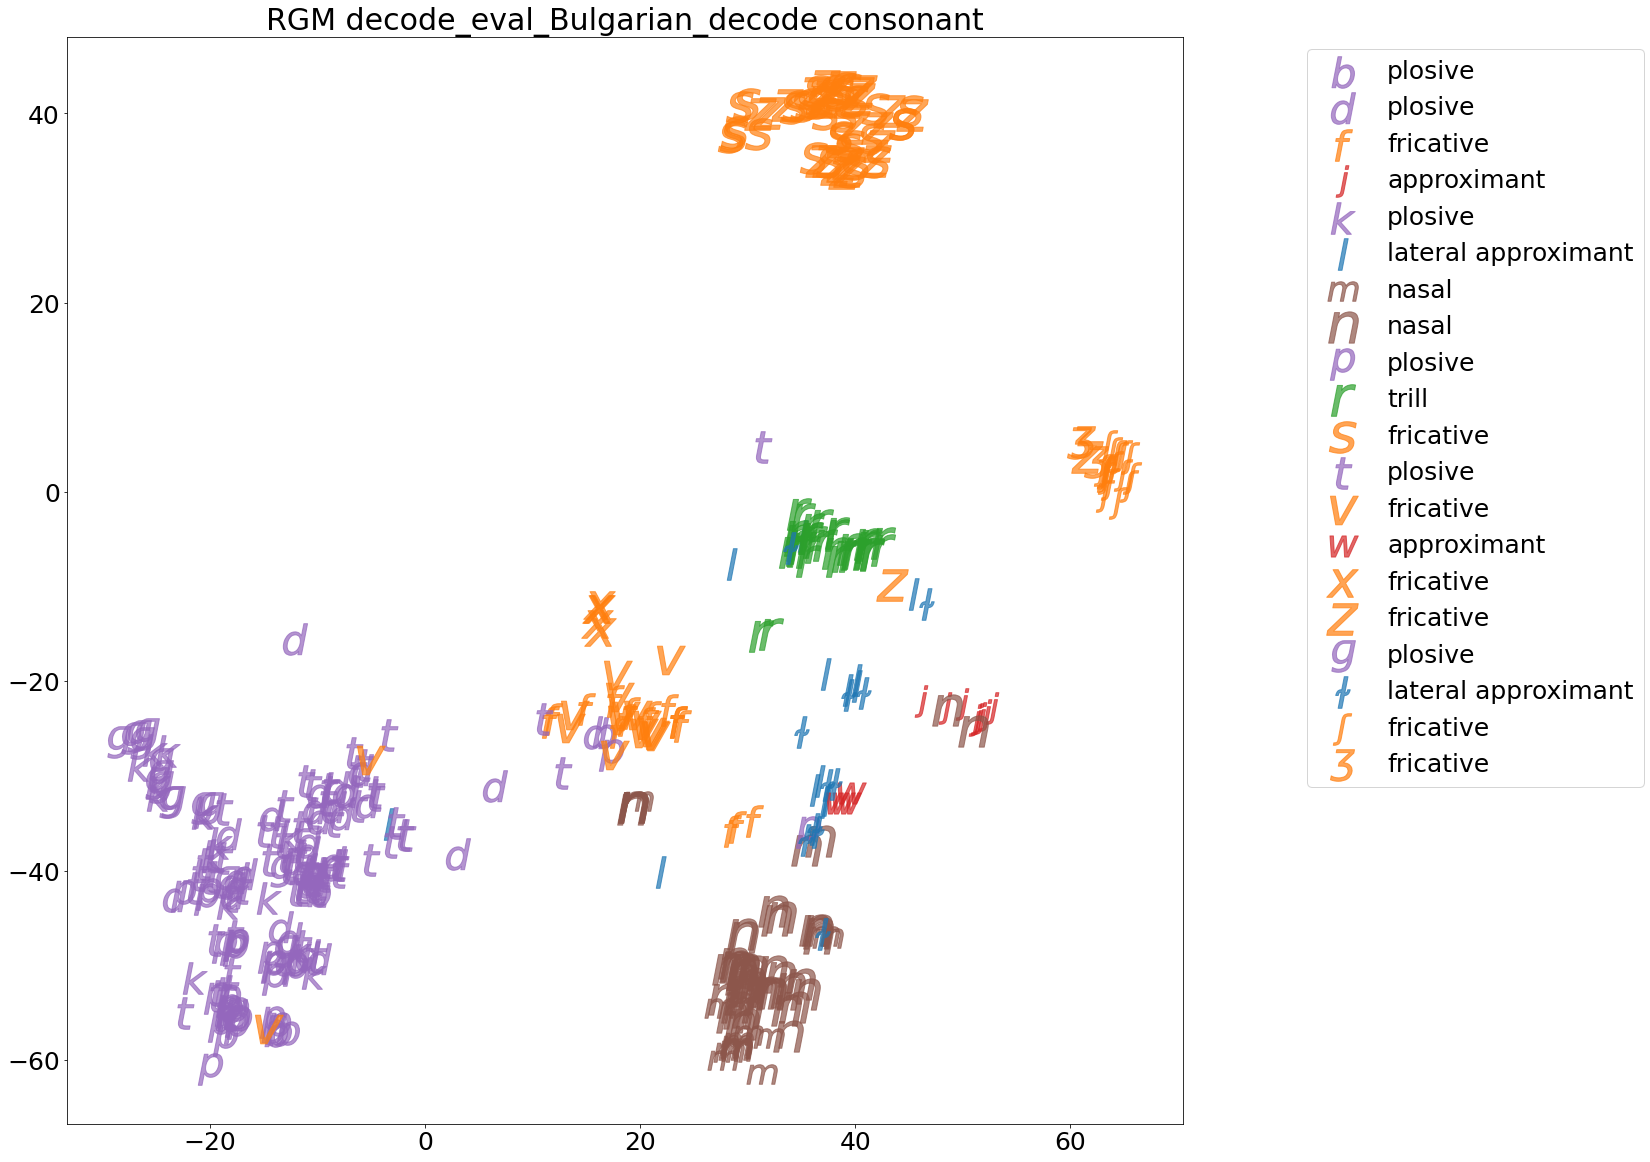

In [26]:
# COMP

cur_embeddings = all_embeddings[1]
cur_labels = all_labels[1]
cur_langs = all_langs[1]
cur_save_dir = os.path.join(PLOT_SAVE_DIR,exp_dirs[1].split('/')[-1])
os.makedirs(cur_save_dir,exist_ok = True)

cur_tsne = tsne_trans[len(all_embeddings[0]):]

unique_langs = lang2phs.keys()


for lang in sorted(unique_langs, reverse = True):
    for cat in PLOT_CAT.split():
        fig = plt.figure(figsize = (20,20))
        ax = fig.add_subplot(111)

        for ph in lang2phs[lang]:
            prop = train_units_dict[ph]
            if prop[0] == cat:
                choose_flag = np.logical_and(cur_labels == ph, cur_langs == lang)
                cur_cur_tsne = cur_tsne[choose_flag]
                cur_cur_tsne = cur_cur_tsne[:int(len(cur_cur_tsne) / SUBSAMPLE_PLOT) + 1]
                if prop[0] == 'vowel' and COLOR_TYPE_VOWEL == 'Height':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[1], marker = '$' + ph + '$', 
                               color = color_palette[heights.index(prop[1])], alpha = 0.7, s = 1000)
                if prop[0] == 'vowel' and COLOR_TYPE_VOWEL == 'Backness':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[2], marker = '$' + ph + '$', 
                               color = color_palette[backs.index(prop[2])], alpha = 0.7, s = 1000)
                if prop[0] == 'consonant' and COLOR_TYPE_CONS == 'Place':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[1], marker = '$' + ph + '$', 
                               color = color_palette[places.index(prop[1])], alpha = 0.7, s = 1000)
                if prop[0] == 'consonant' and COLOR_TYPE_CONS == 'Manner':
                    ax.scatter(cur_cur_tsne[:,0], cur_cur_tsne[:,1],label = prop[2], marker = '$' + ph + '$', 
                               color = color_palette[manners.index(prop[2])], alpha = 0.7, s = 1000)
        ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')      
        ax.set_title(COMP_FLAG.upper() + ' ' + lang + ' ' + cat)
        fig.savefig(os.path.join(cur_save_dir, COMP_FLAG.upper() + ' ' + lang + ' ' + cat + '.png'))

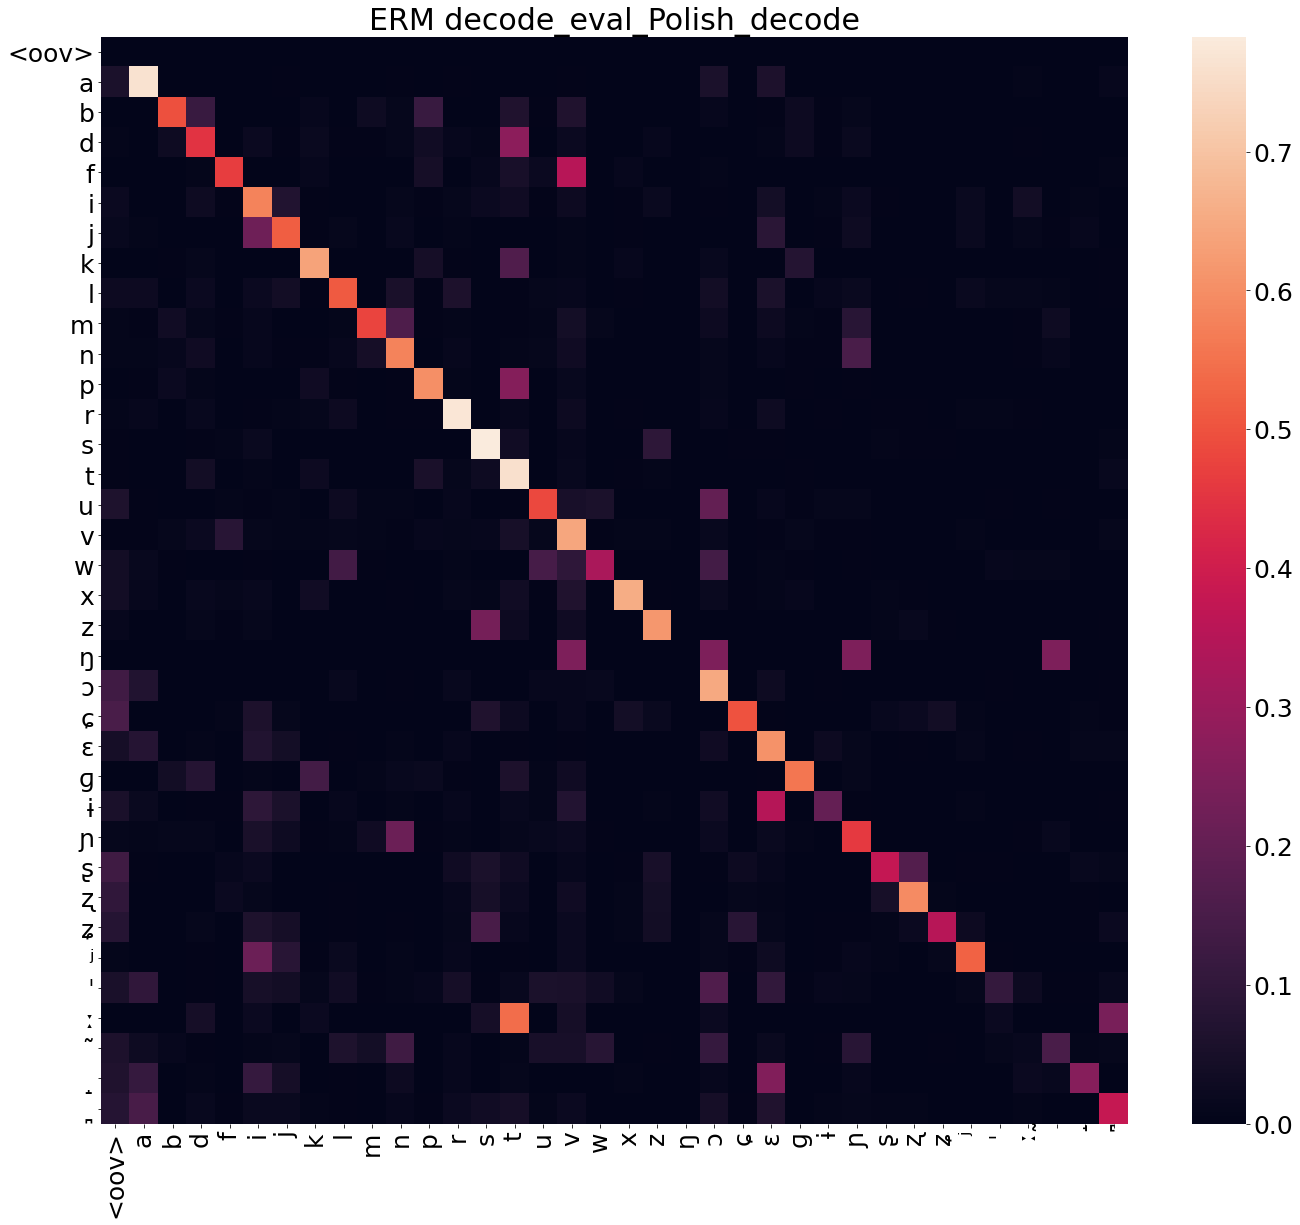

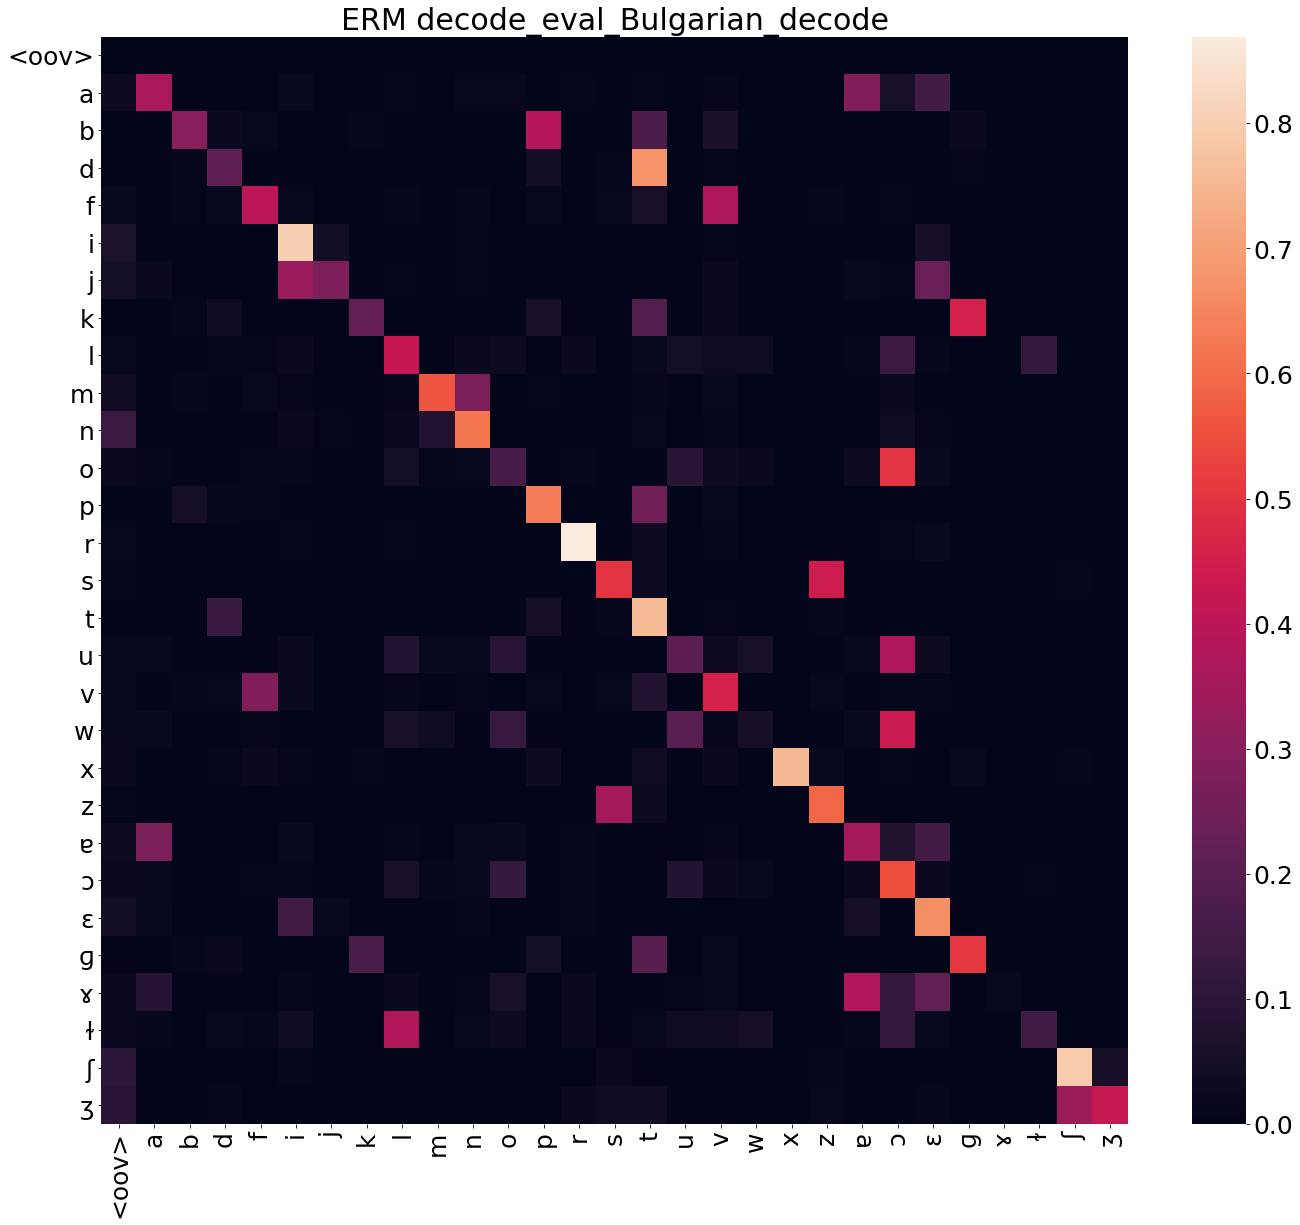

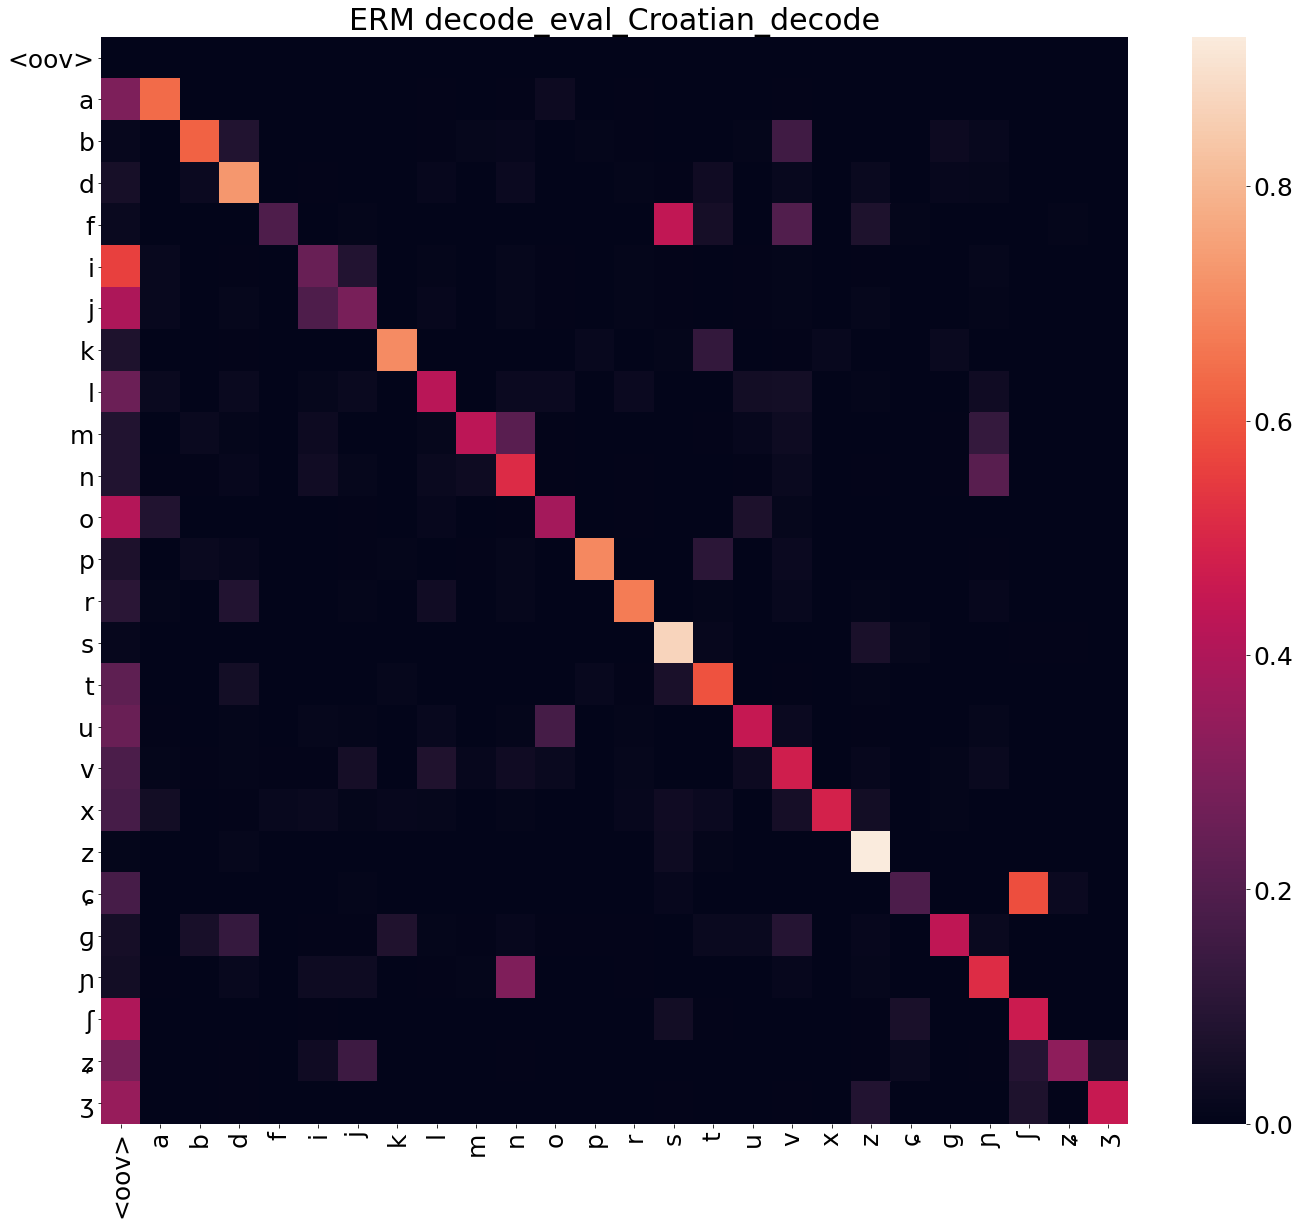

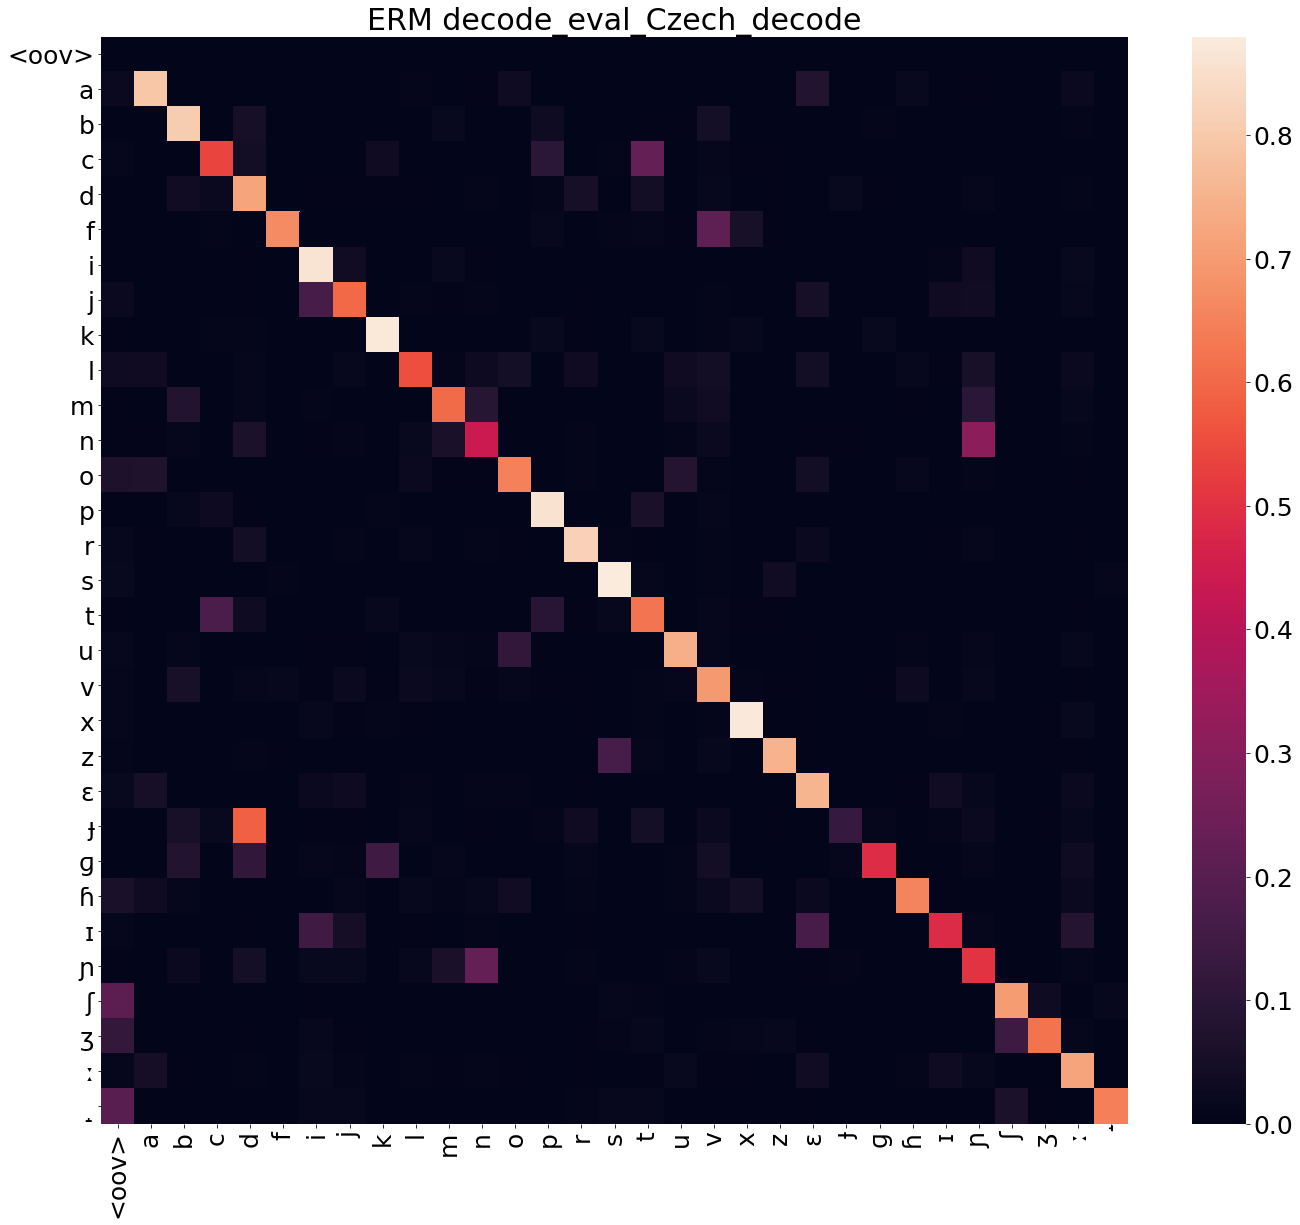

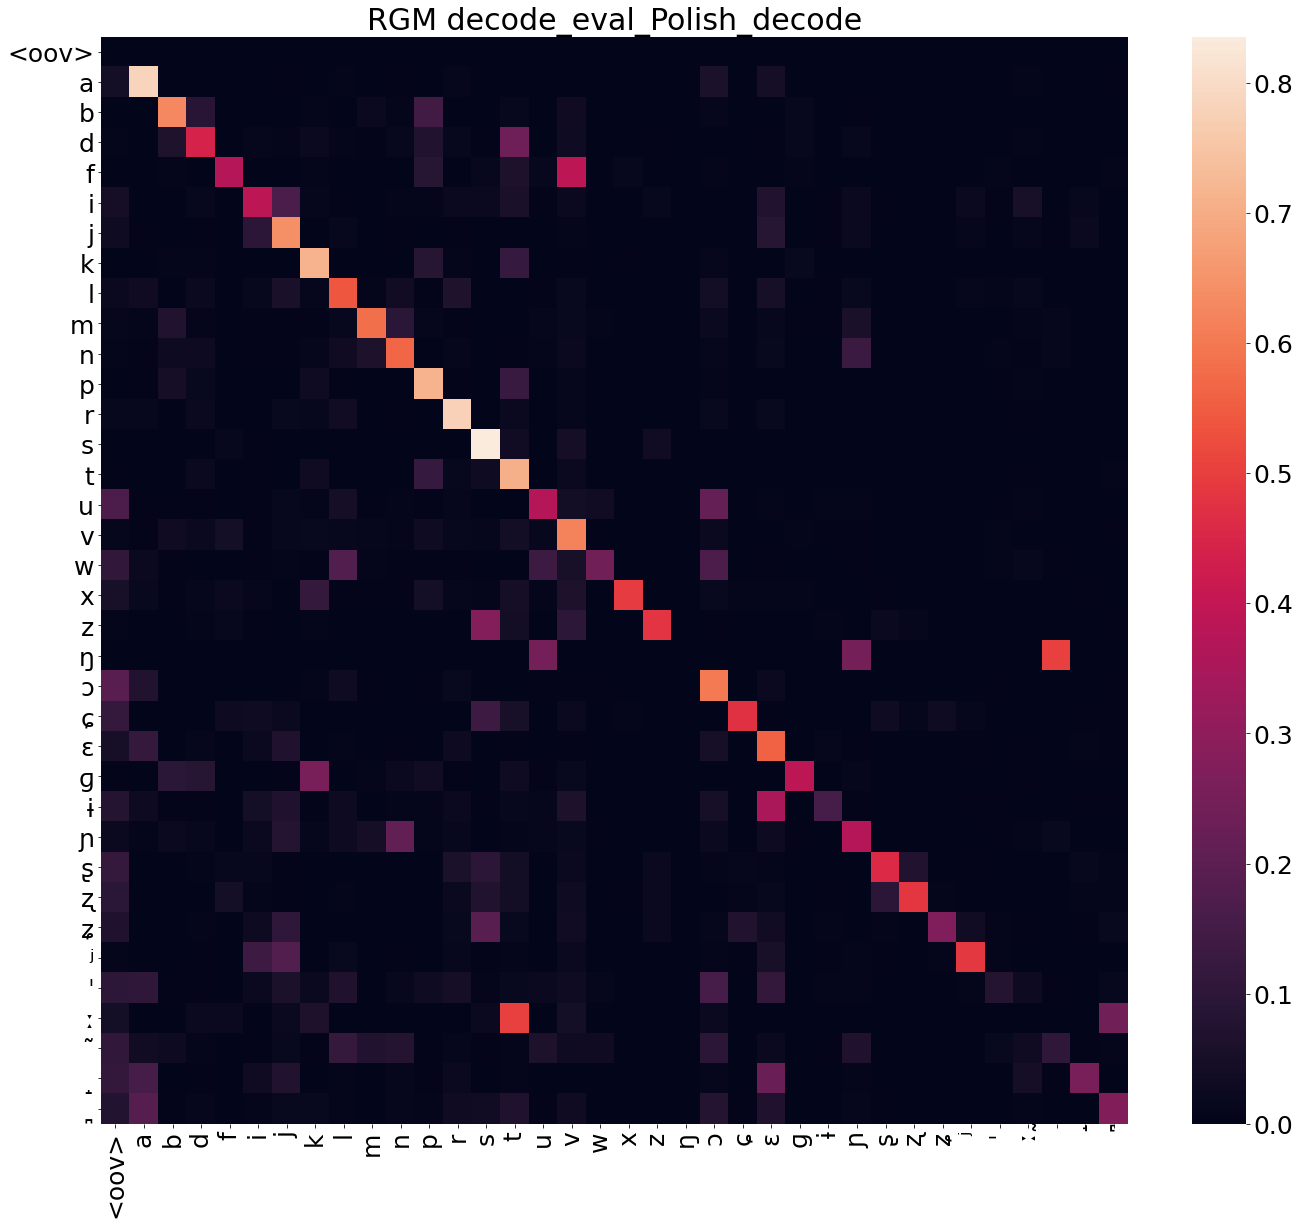

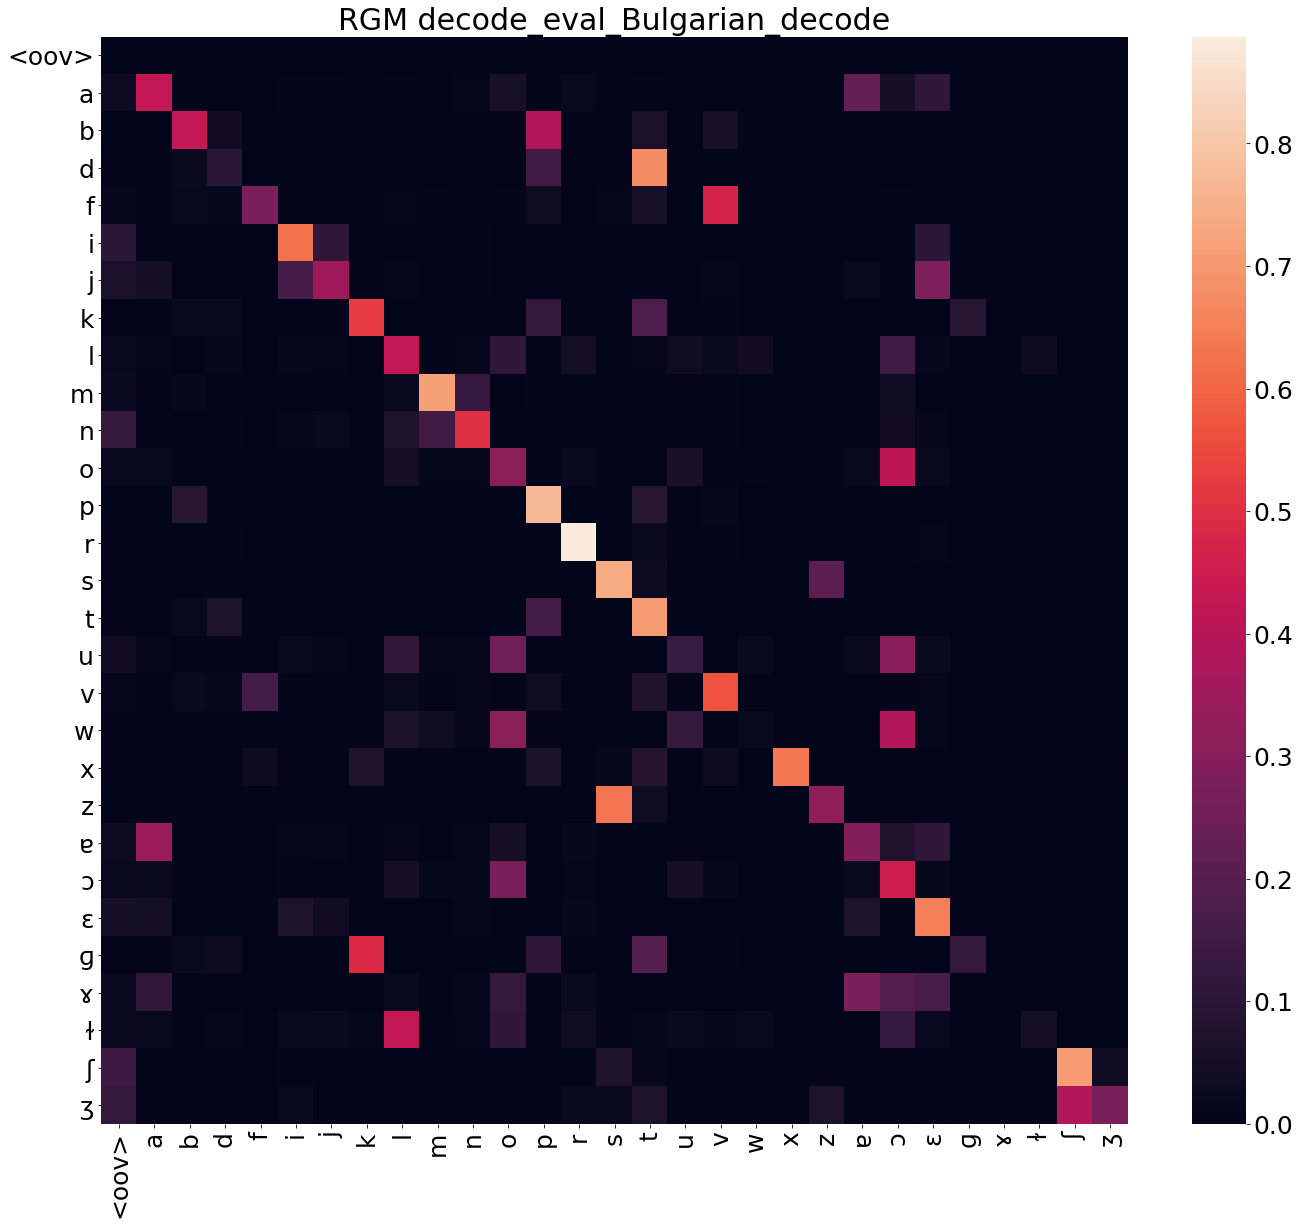

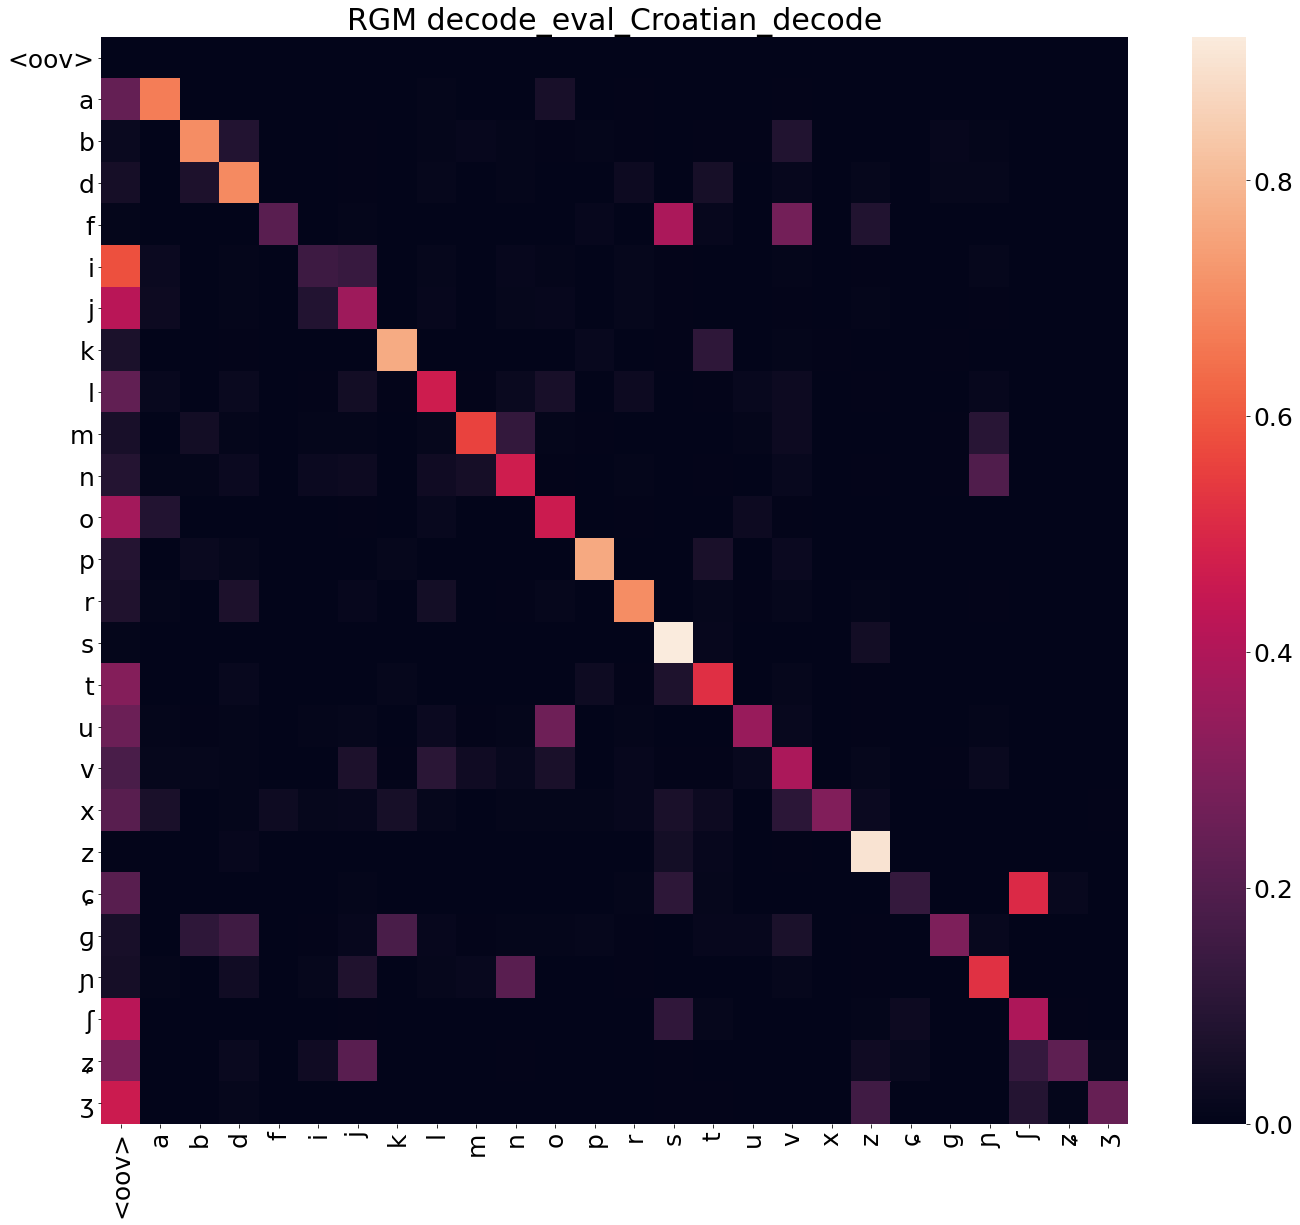

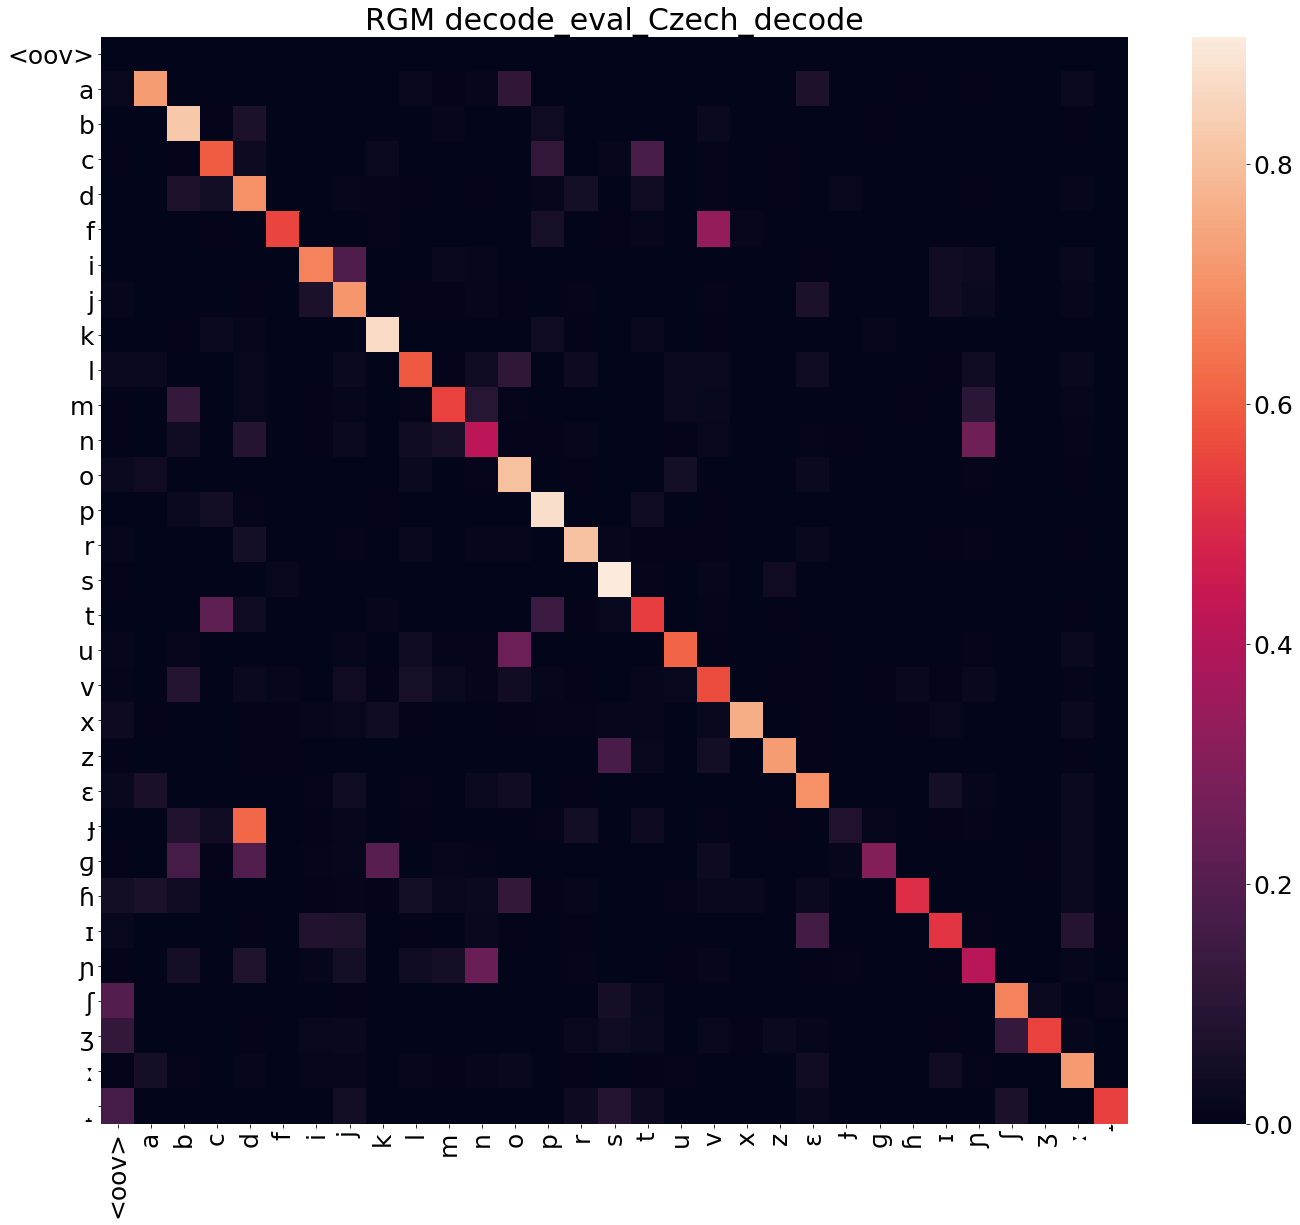

In [28]:

for data_dir in exp_dirs:
    cur_save_dir = os.path.join(MAT_SAVE_DIR,data_dir.split('/')[-1])
    os.makedirs(cur_save_dir,exist_ok = True)
    if COMP_FLAG in data_dir:
        exp = COMP_FLAG
    else:
        exp = 'erm'
    lang_dirs = os.listdir(data_dir)
    for lang_dir in lang_dirs:
        lang_gt = []
        lang_pred = []
        if 'result' not in lang_dir and 'log' not in lang_dir:
            json_fn = os.path.join(data_dir, lang_dir, 'embedding.1.json')
            with open(json_fn,'rb') as f:
                lang_data = pickle.load(f)
                for key in sorted(lang_data.keys()):
                    ph_label_true = id2phs[str(lang_data[key]['GT'][0])]
                    ph_label_pred = id2phs[str(lang_data[key]['pred'])]
                    
                    lang_gt.append(ph_label_true)
                    lang_pred.append(ph_label_pred)
            
            all_phs = np.unique(np.concatenate([lang_gt, ['<oov>']]))
#             print(all_phs)
            for p_idx in range(len(lang_pred)):
                if lang_pred[p_idx] not in all_phs:
                    lang_pred[p_idx] = '<oov>'
                    
            conf_mat = confusion_matrix(lang_gt, lang_pred, normalize='true')
            df_cm = pd.DataFrame(conf_mat, index = [i for i in all_phs],columns = [i for i in all_phs])
            plt.figure(figsize = (23,20))
            sns.heatmap(df_cm,xticklabels=True, yticklabels=True)
            plt.title(exp.upper() + ' ' + lang_dir)
            plt.savefig(os.path.join(cur_save_dir, exp.upper() + ' ' + lang_dir + '.png'))